# Example of generation of valid data mask using a predicate

Notebook showing an example of predicate for generation of valid data mask 

In [1]:
%matplotlib inline

import datetime

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import CRS, BBox, DataCollection

from eolearn.core import EONode, EOTask, EOWorkflow, FeatureType, OutputTask
from eolearn.io import SentinelHubInputTask

Define ROI BBOX and time interval

In [2]:
roi_bbox = BBox(bbox=[12.14, 45.36, 12.55, 45.54], crs=CRS.WGS84)
time_interval = ("2020-06-01", "2020-06-23")

### Workflow to merge the cloud mask with the mask defining where reflectance data is available

The predicate merges the cloud mask with the `dataMask` mask which defines where satellite data is available. For orbits covering partially the ROI, the mask values will be 0, as is shown in this example.

In [3]:
class AddValidDataMaskTask(EOTask):
    def execute(self, eopatch):
        eopatch.mask["VALID_DATA"] = eopatch.mask["dataMask"].astype(bool) & ~(eopatch.mask["CLM"].astype(bool))
        return eopatch

In [4]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B02", "B03", "B04"],
    bands_feature=(FeatureType.DATA, "trueColorBands"),
    additional_data=[(FeatureType.MASK, "dataMask"), (FeatureType.MASK, "CLM")],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)
input_node = EONode(input_task)

add_valmask_node = EONode(AddValidDataMaskTask(), inputs=[input_node])

output_node = EONode(OutputTask("final_eopatch"), inputs=[add_valmask_node])

### Run workflow

In [5]:
workflow = EOWorkflow([input_node, add_valmask_node, output_node])

result = workflow.execute({input_node: {"bbox": roi_bbox, "time_interval": time_interval}})

### Plot results

In [6]:
eopatch = result.outputs["final_eopatch"]

eopatch

EOPatch(
  data={
    trueColorBands: numpy.ndarray(shape=(9, 118, 205, 3), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(9, 118, 205, 1), dtype=uint8)
    VALID_DATA: numpy.ndarray(shape=(9, 118, 205, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(9, 118, 205, 1), dtype=bool)
  }
  meta_info={
    size_x: 205
    size_y: 118
    time_difference: 7200.0
    time_interval: ('2020-06-01T00:00:00', '2020-06-23T23:59:59')
  }
  bbox=BBox(((12.14, 45.36), (12.55, 45.54)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2020, 6, 2, 10, 18, 8), ..., datetime.datetime(2020, 6, 22, 10, 18, 9)], length=9
)

In [7]:
def plot_timestamp(eop, timestamp_idx):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
    ax[0][0].imshow(np.clip(2.5 * eop.data["trueColorBands"][timestamp_idx][..., [2, 1, 0]], 0, 1))
    ax[0][0].set_title("True color image")

    ax[0][1].imshow(np.squeeze(eop.mask["VALID_DATA"][timestamp_idx]), cmap="gray")
    ax[0][1].set_title("VALID_DATA")

    ax[1][0].imshow(np.squeeze(eop.mask["dataMask"][timestamp_idx]), cmap="gray")
    ax[1][0].set_title("dataMask")

    ax[1][1].imshow(np.squeeze(eop.mask["CLM"][timestamp_idx]), cmap="gray")
    ax[1][1].set_title("CLM");

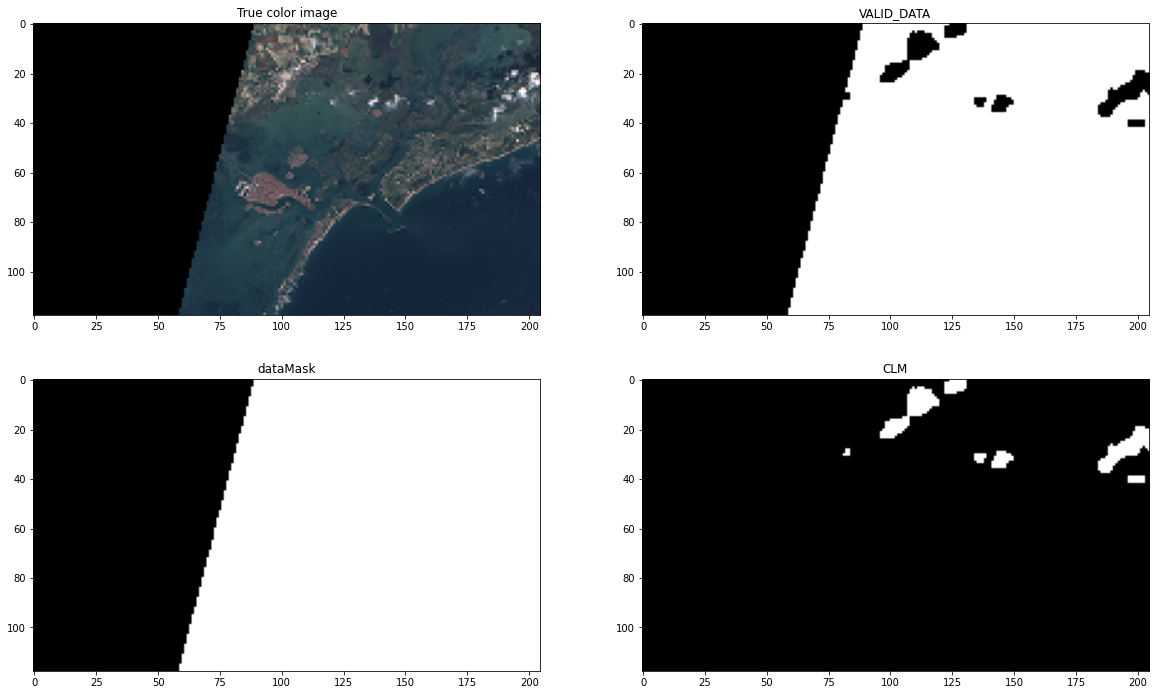

In [8]:
# In this case part of the image is outside 'orbit', and part is covered with (small) clouds.
# `VALID_DATA` is constructed from both.


plot_timestamp(eopatch, 5)

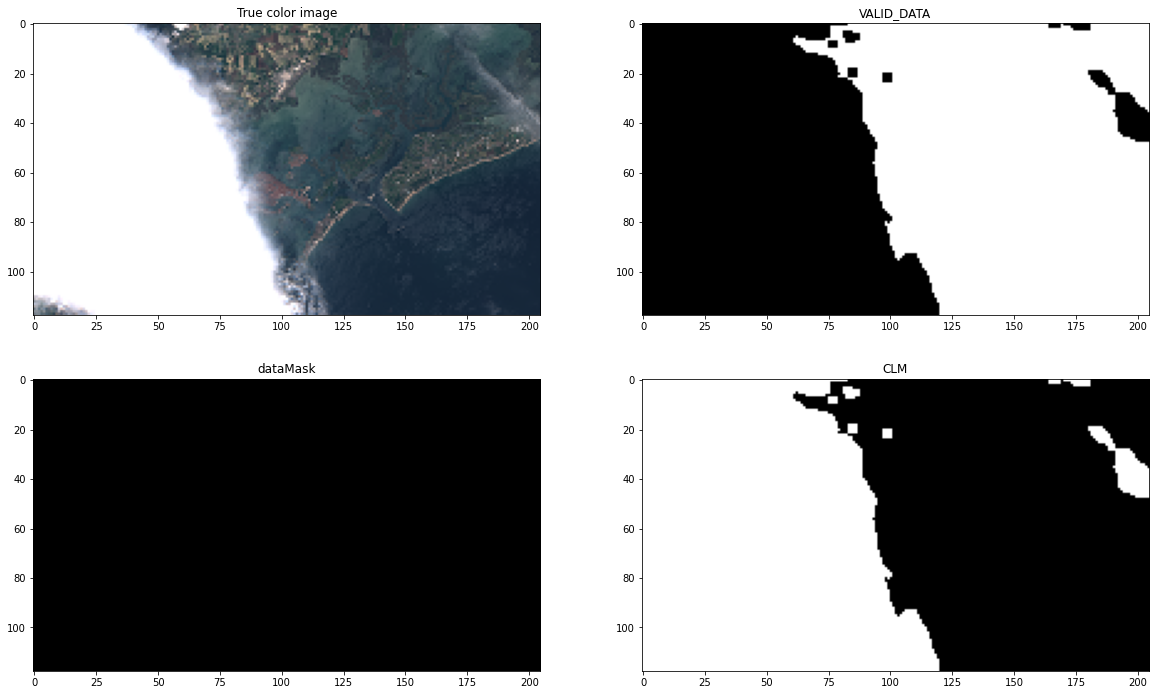

In [9]:
# In this case all pixels have valid data (dataMask==0), but there is a cloud, so `VALID_DATA` is a negate of `CLM` mask

plot_timestamp(eopatch, 6)